# MNSIT-Sequential模板

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import timeit
%matplotlib inline

# 载入数据

In [2]:
set_train = dset.MNIST('./MNIST', train=True, transform=T.ToTensor(), download=True)
loader_train = DataLoader(set_train, batch_size=64)
set_test = dset.MNIST('./MNIST', train=False, transform=T.ToTensor(),download=True)
loader_test = DataLoader(set_test, batch_size=64)

print("训练集大小：",set_train.train_data.size())
print("训练集标签：",set_train.train_labels.size())
print("测试集大小：",set_test.test_data.size())
print("测试集标签：",set_test.test_labels.size())
type(set_train[0]) #数据集的索引是tuple

训练集大小： torch.Size([60000, 28, 28])
训练集标签： torch.Size([60000])
测试集大小： torch.Size([10000, 28, 28])
测试集标签： torch.Size([10000])


tuple

# 显示MNIST数据集图像

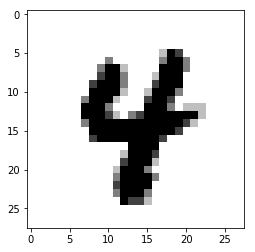

In [3]:
i=np.random.randint(0,60000) #随机数
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")

# 初始化一些参数

In [13]:
# 打印loss的频率
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # 读取 N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        check_accuracy(model, loader_test)
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x).cuda()
            y_var = Variable(y).cuda()
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
                   
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x, volatile=True).cuda()

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# 构造模型 MyLeNet

In [5]:
# MyNeLet
Net = nn.Sequential( 
                    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), #conv1
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2,stride=2), #pool1
                    nn.BatchNorm2d(16), #bn1
                    nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=0), #conv2
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2,stride=2), #pool2
                    nn.BatchNorm2d(32), #bn2
                    Flatten(), 
                    nn.Linear(1152, 400),                    
                    nn.ReLU(inplace=True),
                    nn.Linear(400, 200),                    
                    nn.ReLU(inplace=True),
                    nn.Linear(200, 100),                    
                    nn.ReLU(inplace=True),
                    nn.Linear(100, 10),                   
            )

net =Net.cuda() #实例化模型

x = torch.randn(64, 1, 28, 28) #测试模型是否架构数据
x_var = Variable(x).cuda() # 变量化
ans = net(x_var)        # 喂入模型

# 应该相等
print(ans.size())
np.array_equal(np.array(ans.size()), np.array([64, 10]))

torch.Size([64, 10])


True

# 训练

In [14]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

net.apply(reset) #重置权值
train(net, loss_fn, optimizer, num_epochs=2)
check_accuracy(net, loader_test)

Starting epoch 1 / 2
Checking accuracy on test set
Got 980 / 10000 correct (9.80)
t = 100, loss = 0.0626
t = 200, loss = 0.0648
t = 300, loss = 0.0451
t = 400, loss = 0.2071
t = 500, loss = 0.0966
t = 600, loss = 0.0839
t = 700, loss = 0.0462
t = 800, loss = 0.0040
t = 900, loss = 0.0109
Starting epoch 2 / 2
Checking accuracy on test set
Got 9857 / 10000 correct (98.57)
t = 100, loss = 0.0308
t = 200, loss = 0.0070
t = 300, loss = 0.0129
t = 400, loss = 0.1064
t = 500, loss = 0.0105
t = 600, loss = 0.0506
t = 700, loss = 0.0040
t = 800, loss = 0.0010
t = 900, loss = 0.0062
Checking accuracy on test set
Got 9862 / 10000 correct (98.62)


# 可视化预测

根据图像预测的数字： [[8]]


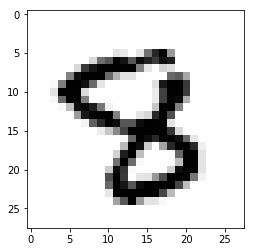

In [16]:
i = np.random.randint(0,60000) #随机数
x = set_train.train_data[i].view([1,1,28,28])
x_var = Variable(x.type(dtype))
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")
scores = Net(x_var) #结果scores是个var
s, i = scores.data.cpu().max(1) #取var的data，放入cpu，计算最大的索引i和分数s
print("根据图像预测的数字：",i.numpy())

# 关于nn.module
本质上只是一个容器，里面装了许多层，装了参数，装了运算规则

# net.parameters()

是一个生成器，返回model的所有参数。
parammeter和variable有些区别，p加入到module中后，默认就是可求导的，但可以修改requires_grad

In [77]:
for i in net.parameters():
    print(i.size(),type(i))

torch.Size([16, 1, 3, 3]) <class 'torch.nn.parameter.Parameter'>
torch.Size([16]) <class 'torch.nn.parameter.Parameter'>
torch.Size([16]) <class 'torch.nn.parameter.Parameter'>
torch.Size([16]) <class 'torch.nn.parameter.Parameter'>
torch.Size([32, 16, 3, 3]) <class 'torch.nn.parameter.Parameter'>
torch.Size([32]) <class 'torch.nn.parameter.Parameter'>
torch.Size([32]) <class 'torch.nn.parameter.Parameter'>
torch.Size([32]) <class 'torch.nn.parameter.Parameter'>
torch.Size([400, 1152]) <class 'torch.nn.parameter.Parameter'>
torch.Size([400]) <class 'torch.nn.parameter.Parameter'>
torch.Size([200, 400]) <class 'torch.nn.parameter.Parameter'>
torch.Size([200]) <class 'torch.nn.parameter.Parameter'>
torch.Size([100, 200]) <class 'torch.nn.parameter.Parameter'>
torch.Size([100]) <class 'torch.nn.parameter.Parameter'>
torch.Size([10, 100]) <class 'torch.nn.parameter.Parameter'>
torch.Size([10]) <class 'torch.nn.parameter.Parameter'>


# net.children()
返回子层的迭代器

In [59]:
for i in net.children():
    print(i)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU (inplace)
MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
ReLU (inplace)
MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
Flatten (
)
Linear (1152 -> 400)
ReLU (inplace)
Linear (400 -> 200)
ReLU (inplace)
Linear (200 -> 100)
ReLU (inplace)
Linear (100 -> 10)


# net.named_children()
返回子层的迭代器,同时还包括一个名字

In [62]:
for lyname,ly in net.named_children():
    print(lyname)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


# net.modules()
返回所有子层的迭代器

In [54]:
nl = list(net.modules())
print(nl[0])
print(nl[1])

Sequential (
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU (inplace)
  (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (8): Flatten (
  )
  (9): Linear (1152 -> 400)
  (10): ReLU (inplace)
  (11): Linear (400 -> 200)
  (12): ReLU (inplace)
  (13): Linear (200 -> 100)
  (14): ReLU (inplace)
  (15): Linear (100 -> 10)
)
Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# net.named_modules()

In [20]:
for lyname,ly in net.named_modules():
    print(lyname,type(ly))

 <class 'torch.nn.modules.container.Sequential'>
0 <class 'torch.nn.modules.conv.Conv2d'>
1 <class 'torch.nn.modules.activation.ReLU'>
2 <class 'torch.nn.modules.pooling.MaxPool2d'>
3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 <class 'torch.nn.modules.conv.Conv2d'>
5 <class 'torch.nn.modules.activation.ReLU'>
6 <class 'torch.nn.modules.pooling.MaxPool2d'>
7 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
8 <class '__main__.Flatten'>
9 <class 'torch.nn.modules.linear.Linear'>
10 <class 'torch.nn.modules.activation.ReLU'>
11 <class 'torch.nn.modules.linear.Linear'>
12 <class 'torch.nn.modules.activation.ReLU'>
13 <class 'torch.nn.modules.linear.Linear'>
14 <class 'torch.nn.modules.activation.ReLU'>
15 <class 'torch.nn.modules.linear.Linear'>


## nn.Sequential(* args)
时序容器，可以添加到module中，前面已经有例子了，也可以传入带name的模式
    
    model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1,20,5)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,64,5)),
          ('relu2', nn.ReLU())
        ]))

## state_dict
保存着module的所有状态（state），以字典形式存储

In [15]:
net.state_dict().keys()

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '3.running_mean', '3.running_var', '4.weight', '4.bias', '7.weight', '7.bias', '7.running_mean', '7.running_var', '9.weight', '9.bias', '11.weight', '11.bias', '13.weight', '13.bias', '15.weight', '15.bias'])

# 其他模型方法
### net.eval()将模型设置为推理模式；
### net.float64()将这个模型数据类型变化
### net.zero_grad() 梯度归0

In [19]:
for name, module in net._modules.items():
    print(type(module))

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class '__main__.Flatten'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
